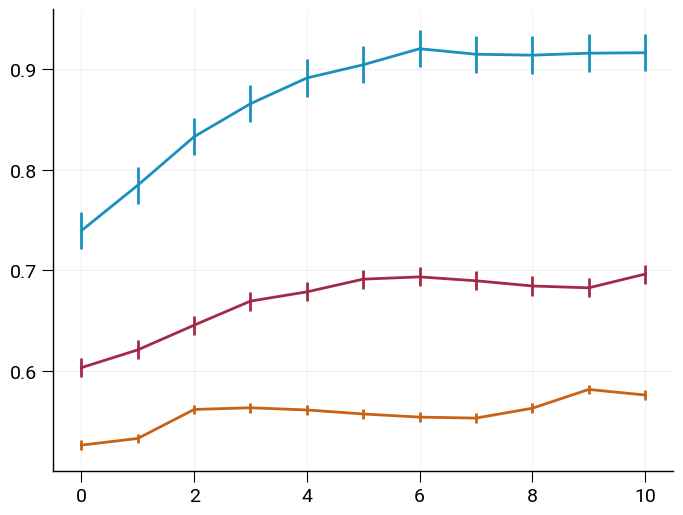

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import sem
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

subjects = ["p1", "p2", "p3", "p4", "p5"]

DIR_DATA = "/data/pt_01880/Experiment1_ODC/paper/decoding"

def _something(input):

    y_mean = []
    for subj in subjects:
        path = Path(DIR_DATA) / subj
        aha = path.glob(f"{input}*")
        for i in aha:
            file = i / "bandpass_none/accuracy.csv"
            data = np.genfromtxt(file, delimiter=',')
            nlayer = np.shape(data)[0]

            y = np.zeros(nlayer)
            for j in range(nlayer):
                y[j] = np.mean(data[j, :])


            y_mean.append(y)

    y_mean = np.array(y_mean)
    y_mean = np.mean(y_mean, axis=0)
    y_sem = sem(y_mean, axis=0)

    plt.errorbar(np.arange(nlayer), y_mean, y_sem, fmt='.-')


for f in ["G", "S", "V"]:
    _something(f)

# TODO
- make plots for single sessions
- make plots across all sessions